In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

columns = inspector.get_columns('Station')
for column in columns:
    print(column["name"], column["type"])

#19550 Measure Records
# 9 Station Records

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


Last Date:  2017-08-23
Query Date:  2016-08-23


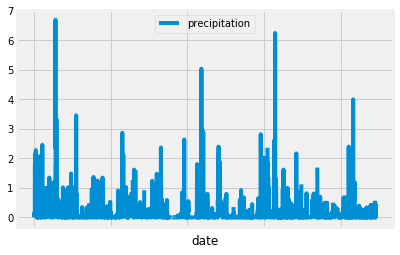

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print("Last Date: ", last_date.date)

# Perform a query to retrieve the data and precipitation scores
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Query Date: ", query_date)

results = (session.query(Measurement.prcp.label("precipitation"), 
                         Measurement.date)
           .filter(Measurement.date >= query_date)
           .order_by(Measurement.date)
           .all())

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results)
df.set_index('date', inplace=True, )

# Sort the dataframe by date
df = df.sort_values('date') 

# Use Pandas Plotting with Matplotlib to plot the data
ax = df.plot()
ax.legend(loc=9)  


In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()


,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?

results = (session.query(Station).count())
print("Station Records: ", results)

Station Records:  9


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

results = (session.query(Measurement.station, func.count(Measurement.station))
           .group_by(Measurement.station)
           .order_by(func.count(Measurement.station).desc())
           .all())

results           

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

results = (session.query(func.min(Measurement.tobs),
                         func.max(Measurement.tobs), 
                         func.avg(Measurement.tobs))
           .filter(Measurement.station == "USC00519281").all())

results    

[(54.0, 85.0, 71.66378066378067)]

Last Date:  2017-08-18
Query Date:  2016-08-18


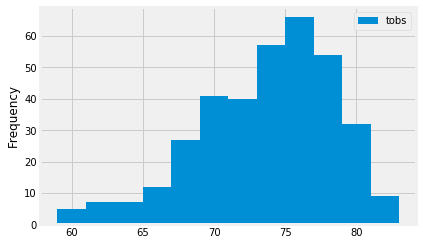

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Calculate the date 1 year ago from the last data point in the database
last_date = (session.query(Measurement.date)
             .filter(Measurement.station == "USC00519281")     
             .order_by(Measurement.date.desc()).first())
print("Last Date: ", last_date.date)

# Perform a query to retrieve the data and precipitation scores
query_date = dt.date(2017, 8, 18) - dt.timedelta(days=365)
print("Query Date: ", query_date)

results = (session.query(Measurement.tobs)
           .filter(Measurement.station == "USC00519281")     
           .filter(Measurement.date >= query_date)
           .all())

df = pd.DataFrame(results)

# Use Pandas Plotting with Matplotlib to plot the data
ax = df.plot(kind='hist', bins=12)


In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return (session.query(func.min(Measurement.tobs), 
                         func.avg(Measurement.tobs), 
                         func.max(Measurement.tobs))
            .filter(Measurement.date >= start_date)
            .filter(Measurement.date <= end_date)
            .all())


# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

print(calc_temps('2017-02-28', '2017-03-05'))

[(64.0, 72.02777777777777, 78.0)]


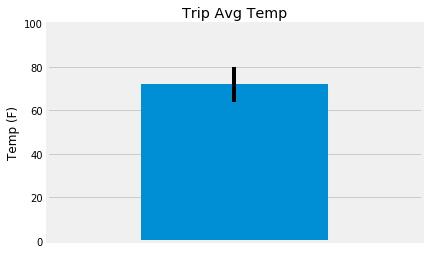

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

results = calc_temps('2017-02-28', '2017-03-05')

df = pd.DataFrame([results[0][1]])

ax = df.plot.bar(yerr=[[results[0][1]-results[0][0]], [results[0][2]-results[0][1]]], legend=False)
ax.set_title("Trip Avg Temp")
ax.set_ylabel("Temp (F)")
ax.set_ylim(0,100)

x_axis = ax.axes.get_xaxis()
x_axis.set_visible(False)

In [20]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# create subquery to be run in select statment.
# doing so allows all 9 stations to return a value

count_stmt = (session.query(func.avg(Measurement.prcp))
              .filter(Measurement.station == Station.station)
              .filter(Measurement.date >= '2017-02-28')
              .filter(Measurement.date <= '2017-03-05')        
              .group_by(Measurement.station)
              .label('cnt'))

results = (session.query(Station.station, 
                         Station.name, 
                         Station.latitude,
                         Station.longitude,
                         Station.elevation,
                         count_stmt)
           .order_by(count_stmt.desc())
           .all())

results


[('USC00517948',
  'PEARL CITY, HI US',
  21.3934,
  -157.9751,
  11.9,
  0.9933333333333333),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.7866666666666667),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  0.7416666666666667),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.6783333333333333),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.5800000000000001),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.46399999999999997),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  0.4566666666666666),
 ('USC00518838',
  'UPPER WAHIAWA 874.3, HI US',
  21.4992,
  -158.0111,
  306.6,
  None),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  None)]

## Optional Challenge Assignment

In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [22]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date

import datetime

start_date = datetime.datetime.strptime("2018-01-01", "%Y-%m-%d")
end_date = datetime.datetime.strptime("2018-01-07", "%Y-%m-%d")

date_list = [start_date + datetime.timedelta(days=x) for x in range(0, (end_date - start_date + datetime.timedelta(days=1)).days)]
results = []

for date in date_list:
    results.append(daily_normals(date.strftime("%m-%d"))[0])

results

[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
# Unpackinto separate lists

tmin_list = [float(result[0]) for result in results]
tavg_list = [float(result[1]) for result in results]
tmax_list = [float(result[2]) for result in results]

# create dataframe
df = pd.DataFrame({"date" : date_list, 
                   "tmin" : tmin_list, 
                   "tavg" : tavg_list,
                   "tmax" : tmax_list})

df.set_index('date', inplace=True)
df.head()

,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


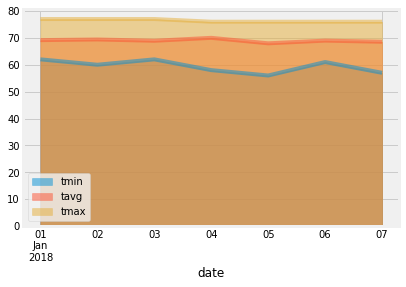

In [24]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot.area(stacked=False)
